In [2]:
get_ipython().magic('matplotlib notebook')
import pandas as pd
import numpy as np
from functools import reduce

#Load Data Set with Lebron's games and statistics
df = pd.read_csv('Teams_LBJ_Stats.csv', sep=';')
df = df.rename(columns={'o:team': 'team'})

#Load Data Sets with seasons 2003 -> 2018 and derive the desired data in order to compute the season W%
rang = np.arange(2003,2018,1)
team = []
season = []
SeasonPercentage = []

for x in rang:
    y = pd.read_csv('C:/Users/mluksik/iCloudDrive/NBA_DataScience/LeBron_W_predictor/{0}'.format(x) + '.csv', sep=';')
    y['W'] = np.where(y['W'] == True, 1, 0)
    y = y.rename(columns={'W':'SeasonPercentage'})
    y = y.groupby('team').agg({'SeasonPercentage': 'mean' , 'season': 'first'})
    team.append(y.index.tolist())
    season.append(y['season'].tolist())
    SeasonPercentage.append(y['SeasonPercentage'].tolist())

# Deriving the new feature -> quality of the opponent (Season Percentage) by merging the datasets on keys 'team' and 'season' features
team = reduce(lambda x,y: x+y,team)
season = reduce(lambda x,y: x+y,season)
SeasonPercentage = reduce(lambda x,y: x+y,SeasonPercentage)
y = {'team':team, 'season': season, 'SeasonPercentage': SeasonPercentage}
y = pd.DataFrame(y)
df = pd.merge(df, y, on=['team', 'season'], how='left')
df = df.drop(['team', 'season', 'Lebron James:steals', 'Lebron James:fouls', 'Lebron James:blocks', 'Lebron James:free throws attempted'], axis=1)

print(len(df))
print(list(df))

1380
['W', 'Lebron James:points', 'Lebron James:assists', 'Lebron James:field goals attempted', 'Lebron James:minutes', 'Lebron James:rebounds', 'Lebron James:three pointers attempted', 'Lebron James:turnovers', 'SeasonPercentage']


In [4]:
# Check of Multicollinearity
df1 = df.drop(['W'], axis=1)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X = add_constant(df1)
pd.Series([variance_inflation_factor(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns)
# no need for a feature elimination

const                                    67.392814
Lebron James:points                       2.093409
Lebron James:assists                      1.089183
Lebron James:field goals attempted        2.545120
Lebron James:minutes                      1.574281
Lebron James:rebounds                     1.134804
Lebron James:three pointers attempted     1.335647
Lebron James:turnovers                    1.040489
SeasonPercentage                          1.077794
dtype: float64

In [5]:
### Creating Validation scores on 4 folds of train and test sets in order to prevent overfitting while controling the C parameter of Logistic Regression:
    ### 4 splits ensure that all the data points will be tested
        ### later, the 75:25 (train set : test set) will be used
        
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression

### Splitting the data on dependent and independet variables
X = df1
y = df['W']

### Testing the validation scores on a range of C parameters in order to find a suitable 
param_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000])
train_scores, test_scores = validation_curve(LogisticRegression(), X, y,
                                            param_name='C',
                                            param_range=param_range, cv=4)

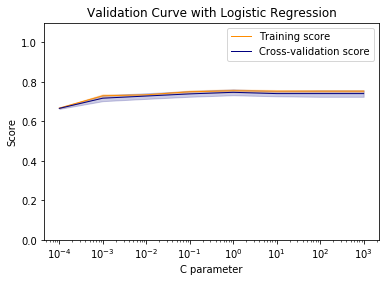

In [6]:
# This code based on scikit-learn validation_plot example
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title('Validation Curve with Logistic Regression')
plt.xlabel('C parameter')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)
lw = 1

plt.semilogx(param_range, train_scores_mean, label='Training score',
            color='darkorange', lw=lw)

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.2,
                color='darkorange', lw=lw)

plt.semilogx(param_range, test_scores_mean, label='Cross-validation score',
            color='navy', lw=lw)

plt.fill_between(param_range, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.2,
                color='navy', lw=lw)

plt.legend(loc='best')
plt.show()

In [7]:
# From the Validation Curve, we can see that the data set doesn't tend to over-fit -> the complexity of the dataset is in order.
# When the C parameter = 1, the Cross-Validation score has the best performance.
# Let's further investigate C = [0.1, 1, 10]

In [8]:
# Based on the results, let's further investigate the accuracy, AUC and recall.

# Cross-validation with the test for the variance of C-parameter (narrowed down to tree options based on the Validation Curve)
from sklearn.model_selection import cross_val_score

for c_param in [0.1, 1, 10]:
    clf = LogisticRegression(C=c_param)

    # accuracy is the default scoring metric
    print('For C parameter = {0}'.format(c_param) + ':')
    print('Cross-validation (accuracy)', cross_val_score(clf, X, y, cv=4))
    # use AUC as scoring metric
    print('Cross-validation (AUC)', cross_val_score(clf, X, y, cv=4, scoring = 'roc_auc'))
    # use recall as scoring metric
    print('Cross-validation (recall)', cross_val_score(clf, X, y, cv=4, scoring = 'recall'))
       # use recall as scoring metric
    print('Cross-validation (precesion)', cross_val_score(clf, X, y, cv=4, scoring = 'precision'))

For C parameter = 0.1:
Cross-validation (accuracy) [0.73121387 0.75942029 0.74492754 0.72093023]
Cross-validation (AUC) [0.76570465 0.80304171 0.76562265 0.74653503]
Cross-validation (recall) [0.76956522 0.92139738 0.91266376 0.90393013]
Cross-validation (precesion) [0.8156682  0.76449275 0.75451264 0.7366548 ]
For C parameter = 1:
Cross-validation (accuracy) [0.72254335 0.75362319 0.76231884 0.75      ]
Cross-validation (AUC) [0.77886057 0.82276766 0.79374341 0.76407822]
Cross-validation (recall)

 [0.77826087 0.89956332 0.91266376 0.90393013]
Cross-validation (precesion) [0.79910714 0.76865672 0.77121771 0.76383764]
For C parameter = 10:
Cross-validation (accuracy) [0.72254335 0.75072464 0.75652174 0.73255814]
Cross-validation (AUC) [0.77634933 0.82705918 0.80349345 0.76855895]
Cross-validation (recall) [0.76521739 0.88646288 0.89956332 0.88646288]
Cross-validation (precesion) [0.80733945 0.77186312 0.77153558 0.75464684]


In [11]:
# As we can see, the performance with the C = 1 is performing better than C=10.
# Also, the C=1 model outperforms the C=0.01 when it comes to AUC and accuracy. The trade off between racall and precision is relatively similar to the previous case (without the feature: Season Percentage)
# # Based on the same arguments introduced in the 1st model, the C=1 is a suitable option.

In [12]:
# Let's investigate the Confusion Matrix, Accuracy, Precision, and Recall for C=1
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = LogisticRegression(C=1).fit(X_train, y_train)

clf_predicted = clf.predict(X_test)
confusion = confusion_matrix(y_test, clf_predicted)

print('Logistic regression classifier (default settings)\n', confusion)

print('Accuracy: {:.2f}'.format(accuracy_score(y_test, clf_predicted)))
print('Precision: {:.2f}'.format(precision_score(y_test, clf_predicted)))
print('Recall: {:.2f}'.format(recall_score(y_test, clf_predicted)))

Logistic regression classifier (default settings)
 [[ 58  57]
 [ 31 199]]
Accuracy: 0.74
Precision: 0.78
Recall: 0.87


In [14]:
# Comparing the results from Model with/without the feature "Season Percentage" on the same train and test sets:
    # the new feature improved the model by 1% of accuracy, 2% of precision. 2% of recall.

C:\Users\mluksik\PycharmProjects\googleapi\venv\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


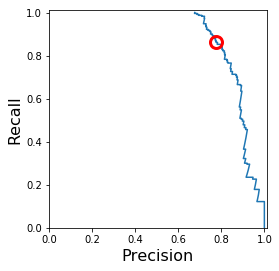

In [15]:
# ### Precision-recall curves
from sklearn.metrics import precision_recall_curve

# ### Decision functions
y_scores_lr = clf.fit(X_train, y_train).decision_function(X_test)
y_score_list = list(zip(y_test[0:20], y_scores_lr[0:20]))


precision, recall, thresholds = precision_recall_curve(y_test, y_scores_lr)
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]

plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.axes().set_aspect('equal')
plt.show()

In [16]:
# The Recall and Precision trade-off is captured above. The current state of the model displayed by the red circle.

C = 0.100  accuracy = 0.739   AUC = 0.781
C = 1.000  accuracy = 0.745   AUC = 0.802


C:\Users\mluksik\PycharmProjects\googleapi\venv\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


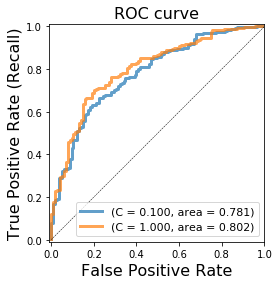

In [19]:
# Plotting the ROC curves for C=0,1 and C = 1
from sklearn.metrics import roc_curve, auc
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
for g in [0.1, 1]:
    clf = LogisticRegression(C=g).fit(X_train, y_train)
    y_score_svm = clf.decision_function(X_test)
    fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    accuracy_svm = clf.score(X_test, y_test)
    print("C = {:.3f}  accuracy = {:.3f}   AUC = {:.3f}".format(g, accuracy_svm,
                                                                    roc_auc_svm))
    plt.plot(fpr_svm, tpr_svm, lw=3, alpha=0.7,
             label='(C = {:0.3f}, area = {:0.3f})'.format(g, roc_auc_svm))

plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.plot([0, 1], [0, 1], color='k', lw=0.5, linestyle='--')
plt.legend(loc="lower right", fontsize=11)
plt.title('ROC curve', fontsize=16)
plt.axes().set_aspect('equal')

plt.show()

In [20]:
#The AUC for C=1 is higher, which also supports the decision to build the model this way.

In [21]:
# As the choice of the C parameter was done.
# The model complexity is not leading to over/under fitting => tested on 4 folds. 
# Let's fit the model to all the data points available in order to achieve the best performance
  # -> the number of observation has nothing to do with over fitting -> that is problem of the model complexity
  
# Creating new observations from the NBA Finals Game 1,2,3,4 (previously not seen in the data set) -> and predict the W probability for these games.

clf = LogisticRegression(C=1).fit(X, y)

# G1:
LBJ_stats_first_game_1 = {'Lebron James:points': [51],
                        'Lebron James:assists': [8],
                        'Lebron James:field goals attempted': [32],
                        'Lebron James:minutes': [48],
                        'Lebron James:three pointers attempted': [7],
                        'Lebron James:turnovers': [5],
                        'Lebron James:rebounds':[8],
                        'SeasonPercentage': [0.707]}

g1 = pd.DataFrame(data=LBJ_stats_first_game_1)
y_predict1 = clf.predict_proba(g1)

#G2:
LBJ_stats_first_game_2 = {'Lebron James:points': [29],
                        'Lebron James:assists': [13],
                        'Lebron James:field goals attempted': [20],
                        'Lebron James:minutes': [44],
                        'Lebron James:three pointers attempted': [4],
                        'Lebron James:turnovers': [5],
                        'Lebron James:rebounds':[9],
                        'SeasonPercentage': [0.707]}

g2 = pd.DataFrame(data=LBJ_stats_first_game_2)
y_predict2 = clf.predict_proba(g2)

#G3:
LBJ_stats_first_game_3 = {'Lebron James:points': [33],
                        'Lebron James:assists': [11],
                        'Lebron James:field goals attempted': [28],
                        'Lebron James:minutes': [47],
                        'Lebron James:three pointers attempted': [6],
                        'Lebron James:turnovers': [4],
                        'Lebron James:rebounds':[10],
                        'SeasonPercentage': [0.707]}

g3 = pd.DataFrame(data=LBJ_stats_first_game_3)
y_predict3 = clf.predict_proba(g3)

#G4:
LBJ_stats_first_game_4 = {'Lebron James:points': [23],
                        'Lebron James:assists': [8],
                        'Lebron James:field goals attempted': [13],
                        'Lebron James:minutes': [41],
                        'Lebron James:three pointers attempted': [1],
                        'Lebron James:turnovers': [6],
                        'Lebron James:rebounds':[7],
                        'SeasonPercentage': [0.707]}

g4 = pd.DataFrame(data=LBJ_stats_first_game_4)
y_predict4 = clf.predict_proba(g4)

print('Probability of Cavs winning the G1: ', y_predict1)
print('Probability of Cavs winning the G2: ', y_predict2)
print('Probability of Cavs winning the G3: ', y_predict3)
print('Probability of Cavs winning the G4: ', y_predict4)

Probability of Cavs winning the G1:  [[0.36327905 0.63672095]]
Probability of Cavs winning the G2:  [[0.64070579 0.35929421]]
Probability of Cavs winning the G3:  [[0.77474326 0.22525674]]
Probability of Cavs winning the G4:  [[0.81195272 0.18804728]]


In [ ]:
# Okay, these numbers seems to be much more reasonable than the one in the model 1.
# The outcome is clear
#   -> LeBron James himself could not do much more to increase the probability of Win.
#   -> Even when delivering great performance in G1 ad G2, the probability was only 63%.
#   -> This model proves that the result of the Game was depending more on the other players' performance and that the quality of the opponent is a very significant feature.

In [22]:
# Lebron James would need to put up these number to increase the change of Cleveland beating GSW to 90%:
LBJ_stats_first_game_X = {'Lebron James:points': [50],
                        'Lebron James:assists': [15],
                        'Lebron James:field goals attempted': [30],
                        'Lebron James:minutes': [42],
                        'Lebron James:three pointers attempted': [5],
                        'Lebron James:turnovers': [2],
                        'Lebron James:rebounds':[10],
                        'SeasonPercentage': [0.707]}

gX = pd.DataFrame(data=LBJ_stats_first_game_X)
y_predictX = clf.predict_proba(gX)

print('Probability of Cavs winning the GX: ', y_predictX)

Probability of Cavs winning the GX:  [[0.09324354 0.90675646]]


In [24]:
#Let's see how the feature importance changed compare to the previous model:
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 8,
                            random_state = 0).fit(X_train, y_train)

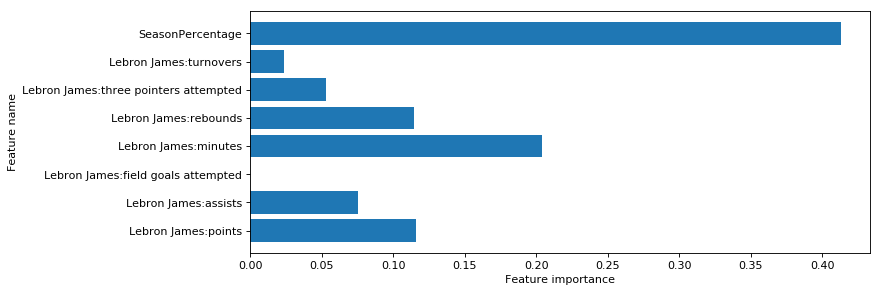

Feature importances: [0.11568497 0.07569575 0.         0.204279   0.11455137 0.05305568
 0.02388006 0.41285317]
['Lebron James:points', 'Lebron James:assists', 'Lebron James:field goals attempted', 'Lebron James:minutes', 'Lebron James:rebounds', 'Lebron James:three pointers attempted', 'Lebron James:turnovers', 'SeasonPercentage']


In [25]:
#Feature importance
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)

plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(clf, list(X_train))
plt.show()

print('Feature importances: {}'.format(clf.feature_importances_))
print(list(X_train))

In [50]:
#Confirmed: The quality of the opponent is the most important feature in this model, and it overshadows the LeBron's statistics.